In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy import optimize
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import MIstack as MIs
from DSH import IOfunctions as IOF
from DSH import SharedFunctions as SF
from DSH import ROIproc as RP

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('SALS tutorial started')

INFO:root:SALS tutorial started


# RheoDLS image analysis

### 1. Open experimental data

DEBUG:root:MIfile object created with filename D:\Chiara\230706\SUF_relax\0.500\imgs\001_STARTUP.raw
DEBUG:root:MIfile - Metadata filename automatically generated: D:\Chiara\230706\SUF_relax\0.500\imgs\001_STARTUP_metadata.ini
DEBUG:root:Now loading MIfile metadata (from filename: D:\Chiara\230706\SUF_relax\0.500\imgs\001_STARTUP_metadata.ini)
DEBUG:root:Loading config file D:\Chiara\230706\SUF_relax\0.500\imgs\001_STARTUP_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']


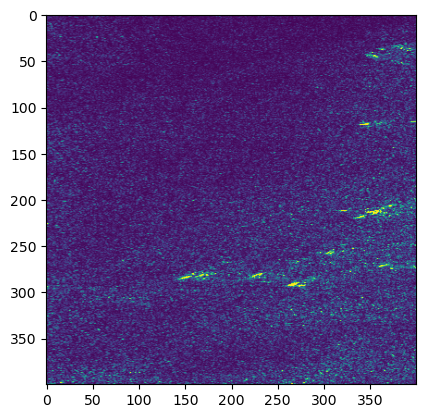

In [2]:
#---------------------------------
froot = r'D:\Chiara\230706\SUF_relax\0.500\imgs'
fname_prefix = '001_STARTUP'
#---------------------------------

imgTimes, imgTimes_hdr = IOF.LoadResFile(os.path.join(froot, fname_prefix+'_imgTimes.dat'), readHeader=True, isolateFirst=0, delimiter='\t', comments='#', missing_values='-')

MIinput = MI.MIfile(os.path.join(froot, fname_prefix+'.raw'))
MIinput.OpenForReading()
plt.imshow(MIinput.GetImage(0))

### 2. Visualize stress and strain from NI DAQ

Sample parameters (calibrated upon loading): Gap=0.700mm; Cross-section area=3.000cm2
1574 stress-strain datapoints read during the acquisition of 9999 images


Text(0, 0.5, '$\\sigma$ [Pa]')

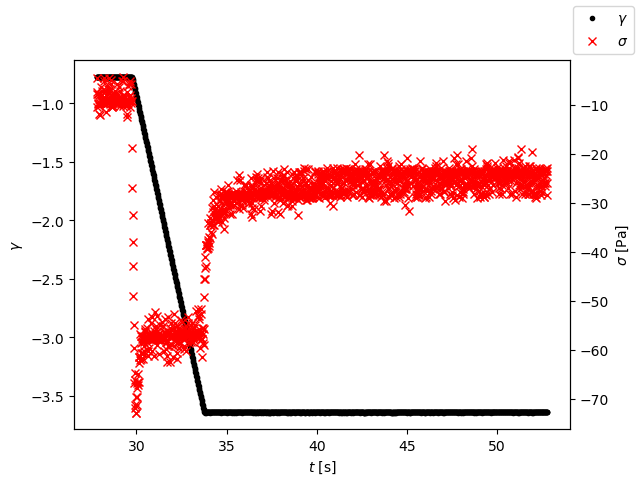

In [3]:
#---------------------------------
Gap = 0.7
Area = 3.0
ForceConversion = 2.2/15 # <-- this means that 2.2 force produces 15V signal in the DAQ (this is the conversion factor on 07/07/2023)
#---------------------------------

print('Sample parameters (calibrated upon loading): Gap={0:.3f}mm; Cross-section area={1:.3f}cm2'.format(Gap, Area))

nan_mask = np.logical_or(np.isnan(imgTimes[:,9]), np.isnan(imgTimes[:,10]))
Rheo_times = imgTimes[~nan_mask,11]
Strain = imgTimes[~nan_mask,9] / Gap
Stress = imgTimes[~nan_mask,10] * ForceConversion / (Area * 1e-4)

print('{0} stress-strain datapoints read during the acquisition of {1} images'.format(len(Rheo_times), len(imgTimes[:,9])))

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(Rheo_times, Strain, 'k.', label=r'$\gamma$')
ax2.plot(Rheo_times, Stress, 'rx', label=r'$\sigma$')
fig.legend()
ax.set_xlabel(r'$t$ [s]')
ax.set_ylabel(r'$\gamma$')
ax2.set_ylabel(r'$\sigma$ [Pa]')

### 3. Initialize ROIproc object

DEBUG:root:2 binary masks created with shape (400, 400)
INFO:root:Set 2 valid ROIs
DEBUG:root:9999 image times loaded (Image number: 9999)
DEBUG:root:Set one single exposure time: 1



|-----------------|
|  ROIproc class: |
|-----------------+---------------
| Input           : MIfile (D:\Chiara\230706\SUF_relax\0.500\imgs\001_STARTUP.raw), 9999 images
| ROIs            : 2 (2 valid, 0 empty)
| Exposure times  : 1, from 1 to 1
|-----------------+---------------


(225.0, 0.0)

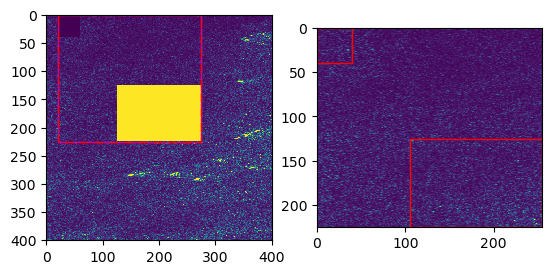

In [4]:
#---------------------------------
ROI_coords = [[40, 20, 40, 40], [200, 175, 150, 100]] # <-- [affine_ROI, nonaffine_ROI] each ROI is defined as [x_center, y_center, width, height]
#---------------------------------

pixel_coords = SF.PixelCoordGrid(MIinput.ImageShape(), extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
ROIs = RP.GenerateMasks(ROI_coords, pixel_coords, common_mask=None)
ROI_proc = RP.ROIproc(MIinput, ROIs, imgTimes=imgTimes[:,3])
ROIbb = ROI_proc.BoundingBox
ROIbb2 = ROI_proc.CropROIbb
im1_crop = ROI_proc.GetImage(0)

print(ROI_proc)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(MIinput.GetImage(0), interpolation='none', extent=(0, ROI_proc.ROIs.shape[1], ROI_proc.ROIs.shape[0], 0))
ax[0].imshow(np.where(ROI_proc.ROIs<0, np.nan, ROI_proc.ROIs), interpolation='none', extent=(0, ROI_proc.ROIs.shape[1], ROI_proc.ROIs.shape[0], 0))
ax[0].add_patch(patches.Rectangle((ROIbb[1], ROIbb[0]), ROIbb[3]-ROIbb[1], ROIbb[2]-ROIbb[0], edgecolor='m', facecolor='none'))
ax[0].add_patch(patches.Rectangle((ROIbb2[0], ROIbb2[1]), ROIbb2[2], ROIbb2[3], ls='-.', edgecolor='r', facecolor='none'))
ax[1].imshow(im1_crop, interpolation='none', extent=(0, ROI_proc.CropROIbb[2], ROI_proc.CropROIbb[3], 0))
for ridx in range(len(ROI_proc.ROIboundingBoxes)):
    _rbb = ROI_proc.ROIboundingBoxes[ridx]
    if ROI_proc.ROI_masks_crop is not None:
        ax[1].imshow(ROI_proc.ROI_masks_crop[ridx], interpolation='none', extent=(_rbb[1], _rbb[3], _rbb[2], _rbb[0]), vmin=0, vmax=1)
    ax[1].add_patch(patches.Rectangle((_rbb[1], _rbb[0]), _rbb[3]-_rbb[1], _rbb[2]-_rbb[0], edgecolor='r', facecolor='none'))
ax[1].set_xlim([0, ROI_proc.CropROIbb[2]])
ax[1].set_ylim([ROI_proc.CropROIbb[3], 0])

### 4. SLS/DLS analysis

First, estimate the processing time with a limited number of time delays

In [10]:
%%time
ROI_proc.doDLS(os.path.join(froot, 'out'), lagtimes=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], g2m1_averageN=100)

INFO:root:ROIproc.doDLS Analysis started! Input data is 9999 images (9999 times, 1 exposure times)
INFO:root:Analysis will resolve 2 ROIs and DLS will be performed on 9999 reference times and 14 lagtimes. Output will be saved in folder D:\Chiara\230706\SUF_relax\0.500\imgs\out
INFO:root:Now starting with SLS...
DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (9999, 1, 2)), Iavg data (shape: (9999, 2)), exptime data (shape: (9999, 2)), buffer images (shape (9999, 225, 255))
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 9999 time points, 14 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 9999, 1] (9999 images)
INFO:root:Contrast (d0) processed
INFO:root:Lagtime 1/13 (d1) completed
INFO:root:Lagtime 2/13 (d2) completed
INFO:root:Lagtime 3/13 (d4) completed
INFO:root:Lagtime 4/13 (d8) completed
INFO:root:Lagtime 5/13 (d16) completed
INFO:root:Lagtime 6/13 (d32) completed
INFO:root:L

CPU times: total: 2min 18s
Wall time: 2min 18s


Based on this, set the number of time delays that can be computed. To log-space $N$ integer time delays, $\tau_i$, ensuring that $\tau_{i+1}$ is strictly larger than $\tau_i$, use:

```python
SF.IntLogSpace(num_points, ppd='auto', first_point=1, autoppd_maxval=None)
```

where:

- ```num_points``` is the number of time delays
- ```ppd``` is the number of points per decade. If set to ```'auto'```, it will be automatically calculated to the closest integer such that the maximum delay is smaller than a given $\tau_{Max}$, set by ```autoppd_maxval```. This optimization is done by the function ```SF.IntLogSpace_GetBestPPD(num_points, max_value, first_point=1)```.
- ```first_point``` is the first point of the series (non-zero)

In [10]:
%%time
auto_lags = SF.IntLogSpace(1000, ppd='auto', autoppd_maxval=ROI_proc.ImageNumber())
print('{0} time delays log-spaced between 1 and {1}: [{2}, {3}, ..., {4}]'.format(len(auto_lags), ROI_proc.ImageNumber(), auto_lags[0], auto_lags[1], auto_lags[-1]))
ROI_proc.doDLS(os.path.join(froot, 'out'), lagtimes=auto_lags, g2m1_averageN=100)

INFO:root:ROIproc.doDLS Analysis started! Input data is 9999 images (9999 times, 1 exposure times)
INFO:root:Analysis will resolve 2 ROIs and DLS will be performed on 9999 reference times and 1001 lagtimes. Output will be saved in folder D:\Chiara\230706\SUF_relax\0.500\imgs\out
INFO:root:Now starting with SLS...


1000 time delays log-spaced between 1 and 9999: [1, 2, ..., 9908]


DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (9999, 1, 2)), Iavg data (shape: (9999, 2)), exptime data (shape: (9999, 2)), buffer images (shape (9999, 225, 255))
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 9999 time points, 1001 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 9999, 1] (9999 images)
INFO:root:Contrast (d0) processed
INFO:root:Lagtime 1/1000 (d1) completed
INFO:root:Lagtime 2/1000 (d2) completed
INFO:root:Lagtime 3/1000 (d3) completed
INFO:root:Lagtime 4/1000 (d4) completed
INFO:root:Lagtime 5/1000 (d5) completed
INFO:root:Lagtime 6/1000 (d6) completed
INFO:root:Lagtime 7/1000 (d7) completed
INFO:root:Lagtime 8/1000 (d8) completed
INFO:root:Lagtime 9/1000 (d9) completed
INFO:root:Lagtime 10/1000 (d10) completed
INFO:root:Lagtime 11/1000 (d11) completed
INFO:root:Lagtime 12/1000 (d12) completed
INFO:root:Lagtime 13/1000 (d13) completed
INFO:root:Lagtime 14/100

CPU times: total: 1h 4min 17s
Wall time: 1h 4min 16s


### 5. Visualizing analysis output

DEBUG:root:DSH.IOfunctions.OpenG2M1s: 2 g2-1 functions loaded from 2 ROIs found in folder D:\Chiara\230706\SUF_relax\0.500\imgs\out


Text(0, 0.5, '$g_2-1$')

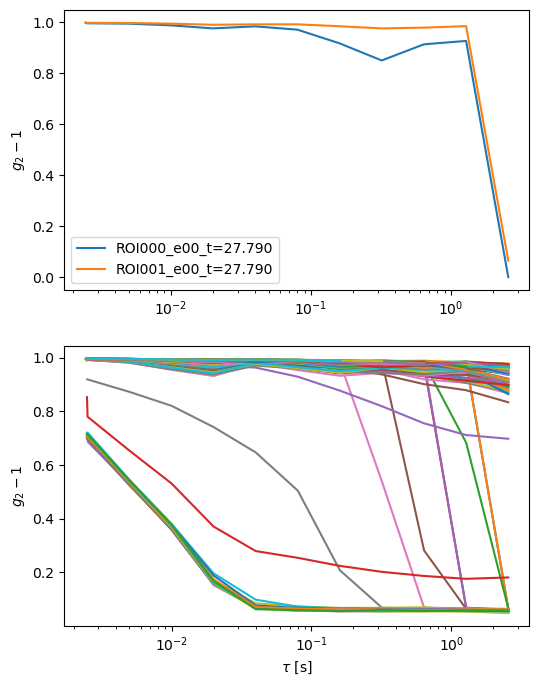

In [9]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = IOF.OpenG2M1s(os.path.join(froot, 'out'))
fig, ax = plt.subplots(nrows=2, figsize=(6, 8))
tidx=0
for i in range(len(g2m1_data)):
    ax[0].plot(lagtimes[i][tidx][1:], g2m1_data[i][tidx][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2)+'_t={0:.3f}'.format(imgtimes[i][tidx]))
ax[0].set_xscale('log')
ax[0].legend()
ridx=-1
for i in range(len(g2m1_data[ridx])):
    ax[1].plot(lagtimes[ridx][i][1:], g2m1_data[ridx][i][1:], label='ROI'+str(ROI_list[ridx]).zfill(3)+'_e'+str(exptime_list[ridx]).zfill(2)+'_t={0:.3f}'.format(imgtimes[ridx][i]))
ax[1].set_xscale('log')
#ax[1].legend()
ax[1].set_xlabel(r'$\tau$ [s]')
ax[0].set_ylabel(r'$g_2-1$')
ax[1].set_ylabel(r'$g_2-1$')

### 6: Run in series

In [ ]:
base_dir = r'D:\Chiara\230706\SUF_relaxnew'
anal_basedir = r'E:\Chiara\230706\SUF_relaxnew\analOut'
subolders_list = ['0.001', '0.003', '0.020', '0.040', '0.075', '0.120', '0.200', '0.500', '0.750', '1.000', '2.000', '0.500bis']
for cursf in subolders_list:
    cur_folder = os.path.join(base_dir, cursf, 'imgs')
    cur_outfolder = os.path.join(anal_basedir, cursf)
    logging.debug('Working folder: ' + str(cur_folder) + ' -- Output folder: ' + str(cur_outfolder))
    flist = SF.FindFileNames(cur_folder, Prefix='0', Ext='.raw')
    for curf in flist:
        cur_prefix = curf[:-4]
        logging.debug('Now processing file ' + str(cur_prefix) + '...')
        
        imgTimes, imgTimes_hdr = IOF.LoadResFile(os.path.join(cur_folder, cur_prefix+'_imgTimes.dat'), readHeader=True, isolateFirst=0, delimiter='\t', comments='#', missing_values='-')
        MIinput = MI.MIfile(os.path.join(froot, fname_prefix+'.raw'))
        MIinput.OpenForReading()
        
        pixel_coords = SF.PixelCoordGrid(MIinput.ImageShape(), extent=None, center=[0, 0], angle=0, coords='cartesian', indexing='xy')
        ROIs = RP.GenerateMasks(ROI_coords, pixel_coords, common_mask=None)
        ROI_proc = RP.ROIproc(MIinput, ROIs, imgTimes=imgTimes[:,3])
         
        auto_lags = SF.IntLogSpace(1000, ppd='auto', autoppd_maxval=ROI_proc.ImageNumber())
        ROI_proc.doDLS(cur_outfolder, lagtimes=auto_lags, g2m1_averageN=100)

DEBUG:root:Working folder: D:\Chiara\230706\SUF_relaxnew\0.001\imgs -- Output folder: E:\Chiara\230706\SUF_relaxnew\analOut\0.001
DEBUG:root:Now processing file 000_REST...
DEBUG:root:MIfile object created with filename D:\Chiara\230706\SUF_relax\0.500\imgs\001_STARTUP.raw
DEBUG:root:MIfile - Metadata filename automatically generated: D:\Chiara\230706\SUF_relax\0.500\imgs\001_STARTUP_metadata.ini
DEBUG:root:Now loading MIfile metadata (from filename: D:\Chiara\230706\SUF_relax\0.500\imgs\001_STARTUP_metadata.ini)
DEBUG:root:Loading config file D:\Chiara\230706\SUF_relax\0.500\imgs\001_STARTUP_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']
DEBUG:root:2 binary masks created with shape (400, 400)
INFO:root:Set 2 valid ROIs
DEBUG:root:9999 image times loaded (Image number: 9999)
DEBUG:root:Set one single exposure time: 1
C:\Users\RHEODLS\miniconda3\envs\dsh\lib\site-packages\dsh-1.0-py3.8.egg\DSH\ROIproc.py:1324: 